# Forecasting Sales Growth

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

In a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) we found a mathematical formula for doing long-term stock forecasting. The formula was derived from the definition of annualized return and separated the stock-return into 3 components: Dividends, change in the Sales Per Share, and change in the P/Sales ratio. If you can predict these 3 components, then you can predict the future stock-return.

This makes intuitive sense, because if you buy a stock and hold it for some years, then you get dividends during those years, and the change in share-price can be decomposed into the change in Sales Per Share and the change in P/Sales ratios using this simple identity:

$$
{Share\ Price_t} = Sales\ Per\ Share_t \cdot \frac{Share\ Price_t}{Sales\ Per\ Share_t} \\
= Sales\ Per\ Share_t \cdot P/Sales_t
$$

So the change in share-price is equal to the change in Sales Per Share multiplied by the change in P/Sales ratio:

$$
\frac{Share\ Price_{t + Years}}{Share\ Price_t} =
\frac{Sales\ Per\ Share_{t + Years} \cdot P/Sales_{t + Years}}{Sales\ Per\ Share_t \cdot P/Sales_t} \\
= \frac{Sales\ Per\ Share_{t + Years}}{Sales\ Per\ Share_t} \cdot
\frac{P/Sales_{t + Years}}{P/Sales_t}
$$

Note that we could also use the change in Earnings Per Share and P/E ratios instead, but the Earnings (aka. Net Income) can be more unstable than Sales, because of temporary fluctuations in profit margins, as well as non-cash and/or non-recurring gains and losses. That is why we will use the P/Sales ratio here.

This paper is a basic statistical study of how to predict the future Sales Growth, and a 
[previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/05_Forecasting_PSales_Ratio.ipynb) studied how to predict the future P/Sales ratio.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display_jpeg

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm

# SimFin imports.
import simfin as sf
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.6.0'

## Config

Setup and configure the various Python packages we are using.

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data-Hub

We use [SimFin](https://github.com/SimFin/simfin) to easily load and process financial data with the following settings:

In [6]:
hub_args = \
{
    # We are interested in the US stock-market.
    'market': 'us',

    # Use last-known values to fill in missing values.
    'fill_method': 'ffill',

    # Refresh the fundamental datasets (Income Statements etc.)
    # every 30 days.
    'refresh_days': 30,

    # Refresh the dataset with shareprices every 10 days.
    'refresh_days_shareprices': 10
}

We can then create a `StockHub` object to handle all the data and signal processing:

In [7]:
%%time
hub = sf.StockHub(**hub_args)

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 14.3 µs


## Signals

We can now use the stock-hub to calculate the signals that we will be using in our analysis, such as Sales Growth, Net Profit Margin, etc.

In [8]:
%%time
# Calculate Growth Signals.
# We set variant='quarterly' to get 4 data-points per year,
# but the data used to calculate the growth signals is TTM.
df_growth_signals = hub.growth_signals(variant='quarterly')

# Calculate Financial Signals. Also 4 data-points per year.
df_fin_signals = hub.fin_signals(variant='quarterly')

# Calculate the 1-year change in the Financial Signals.
df_fin_signals_chg = hub.fin_signals(variant='quarterly',
                                     func=sf.rel_change_ttm_1y)

# Rename columns for the 1-year changes.
def rename_chg(s):
    return s + ' (1Y Change)'
df_fin_signals_chg.rename(mapper=rename_chg, axis='columns', inplace=True)

Dataset "us-income-ttm" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (12 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-52a73c0c.pickle' on disk (5 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-52a73c0c.pickle' on disk (5 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-6d9b5e29.pickle' on disk (5 days old).
- Loading from disk ... Done!
CPU times: user 2.14 s, sys: 112 ms, total: 2.26 s
Wall time: 2.29 s


## Sales Growth Signals

Let us now create a new Pandas DataFrame for the Sales Growth signals that are not calculated by SimFin's built-in functions above. The new signals are:

- `SALES_GROWTH_1Y_FUTURE`: The Sales Growth 1 year into the FUTURE.
- `SALES_GROWTH_3Y_PAST`: The average Sales Growth for the PAST 3 years.
- `SALES_GROWTH_3Y_FUTURE`: The average Sales Growth for the FUTURE 3 years.

These signals will be calculated using SimFin's functions `sf.rel_change` and `sf.mean_log_change`. See the SimFin documentation [here](https://simfin.readthedocs.io/en/latest/rel_change.html) and [here](https://github.com/SimFin/simfin-tutorials/blob/master/03_Growth_Returns.ipynb) for a detailed explanation of what these functions are calculating, as it would be too lengthy to explain it here.

In [9]:
%%time
# Create a new DataFrame to hold the Sales Growth signals.
# This will have the same index as the other DataFrame w. signals.
df_sales_growth = pd.DataFrame(index=df_growth_signals.index)

# Load the Income Statements TTM data and get the Revenue / Sales.
df_income_ttm = hub.load_income(variant='ttm')
df_sales = df_income_ttm[REVENUE]

# Calculate the FUTURE 1-year Sales Growth.
SALES_GROWTH_1Y_FUTURE = 'Sales Growth 1Y FUTURE'
df_sales_growth[SALES_GROWTH_1Y_FUTURE] = \
    sf.rel_change(df=df_sales, freq='ttm', years=1, future=True)

# Calculate the PAST 3-year average Sales Growth.
SALES_GROWTH_3Y_PAST = 'Sales Growth 3Y Avg. PAST'
df_sales_growth[SALES_GROWTH_3Y_PAST] = \
    sf.mean_log_change(df=df_sales, freq='ttm', future=False,
                       min_years=1, max_years=3, annualized=True)

# Calculate the FUTURE 3-year average Sales Growth.
SALES_GROWTH_3Y_FUTURE = 'Sales Growth 3Y Avg. FUTURE'
df_sales_growth[SALES_GROWTH_3Y_FUTURE] = \
    sf.mean_log_change(df=df_sales, freq='ttm', future=True,
                       min_years=1, max_years=3, annualized=True)

# Combine all the signals we have calculated.
dfs = [df_growth_signals, df_fin_signals, df_fin_signals_chg,
       df_sales_growth]
df_signals = pd.concat(dfs, axis=1)

# Remove outliers using "Winsorization".
# The outliers are removed and not "clipped" because it distorts
# correlation-measures and line-fittings.
# We can also exclude some columns from the Winsorization.
exclude_columns = [LOG_REVENUE]
df_signals = sf.winsorize(df=df_signals, quantile=0.03, clip=False,
                          exclude_columns=exclude_columns)

/home/magnus/anaconda3/envs/financeops/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 9.97 s, sys: 81.2 ms, total: 10 s
Wall time: 10 s


These are the resulting signals for ticker MSFT:

In [10]:
df_signals.loc['MSFT'].dropna(how='all').tail()

,Assets Growth,Assets Growth QOQ,Assets Growth YOY,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,...,Quick Ratio (1Y Change),R&D / Gross Profit (1Y Change),R&D / Revenue (1Y Change),Return on Assets (1Y Change),Return on Equity (1Y Change),Return on Research Capital (1Y Change),Share Buyback / FCF (1Y Change),Sales Growth 1Y FUTURE,Sales Growth 3Y Avg. PAST,Sales Growth 3Y Avg. FUTURE
Report Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.011156,0.004813,0.011156,1.425410,-0.045784,-2.336084,-0.041491,-0.483541,-0.018151,0.158263,...,0.055323,-0.030875,-0.028431,1.398651,1.062947,0.031859,1.116586,0.133295,0.115688,NaN
2019-03-31,0.072441,0.017083,0.072441,1.215133,0.046200,0.186557,0.003131,1.109571,0.188565,0.154241,...,-0.135407,-0.019900,-0.013184,1.065506,0.850279,0.020304,0.761958,NaN,0.118985,NaN
2019-06-30,0.107044,0.088404,0.107044,1.367992,0.496992,0.486194,0.186283,0.100593,0.621000,0.140295,...,-0.141209,-0.004979,0.005003,1.139024,0.914156,0.005004,0.595995,NaN,0.120162,NaN
2019-09-30,0.082820,-0.026525,0.082820,1.183644,-0.190263,0.210109,0.207475,-0.134694,0.037593,0.129741,...,-0.016179,0.001007,0.021774,1.016627,0.769937,-0.001006,0.489950,NaN,0.120571,NaN
2019-12-31,0.092463,0.013762,0.092463,0.321457,0.090935,0.383492,0.271981,-0.316112,0.373965,0.133295,...,-0.096547,-0.027191,0.011803,0.209612,0.105661,0.027951,-0.057611,NaN,0.122319,NaN


## Data Years

Let us see how many years of Sales Growth data we have for all the different stocks. First we need a small helper-function:

In [11]:
def data_years(df):
    """
    Calculate the number of years of data in DataFrame `df`.
    
    :param df:
        Pandas DataFrame assumed to have TTM data and be
        grouped by TICKER, and not have any empty NaN rows.

    :return:
        Pandas Series with number of years for each TICKER.
    """

    # Count the number of data-points for each ticker.
    df_len_data = df.groupby(TICKER).apply(lambda df_grp: len(df_grp))

    # Calculate the number of years of data for each ticker.
    # TTM data has 4 data-points per year.
    df_data_years = df_len_data / 4
    
    return df_data_years

On average we have nealy 6 years of Sales Growth data for all these stocks:

In [12]:
# Calculate number of years of Sales Growth data for all stocks.
df_data_years = data_years(df=df_signals[SALES_GROWTH].dropna())

# Show statistics.
df_data_years.describe()

count    1702.000000
mean        5.621328
std         2.522191
min         0.250000
25%         3.500000
50%         6.500000
75%         7.750000
max         9.750000
Name: Sales Growth, dtype: float64

We can also plot a histogram, so we can see the distribution of how many years of Sales Growth data we have for all the individual companies:

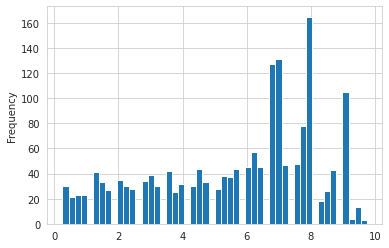

In [13]:
df_data_years.plot(kind='hist', bins=50);

In some of the plots further below, we will compare e.g. the past year's Sales Growth to the 3-year FUTURE average Sales Growth. The summary statistics below shows that on average there is about 3.5 years of such data per company, for a total of nearly 1400 companies:

In [14]:
columns = [SALES_GROWTH, SALES_GROWTH_3Y_FUTURE]
df = df_signals[columns].dropna(how='any')
data_years(df=df).describe()

count    1363.000000
mean        3.591709
std         1.668060
min         0.250000
25%         2.250000
50%         3.750000
75%         5.000000
max         6.750000
dtype: float64

Further below, we will also compare the PAST 3-year average Sales Growth to the FUTURE 3-year average Sales Growth. The statistics below show that there was only about 2.5 years of data-points per company, for a total of about 1100 companies:

In [15]:
columns = [SALES_GROWTH_3Y_PAST, SALES_GROWTH_3Y_FUTURE]
df = df_signals[columns].dropna(how='any')
data_years(df=df).describe()

count    1131.000000
mean        2.483422
std         1.142696
min         0.250000
25%         1.750000
50%         2.250000
75%         3.250000
max         5.000000
dtype: float64

This is a fairly short data-period, because the SimFin database currently does not have any more data. What this means for our analysis, is that we should interpret the results with some caution, as the data may contain trends that are unique for that period in time.

## Plotting Functions

These are small helper-functions for making plots.

In [16]:
def plot_scatter(df, x, y, hue=None, num_samples=5000):
    """
    Make a scatter-plot using a random sub-sample of the data.
    
    :param df:
        Pandas DataFrame with columns named `x`, `y` and `hue`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param hue:
        Either None or string with column-name for the hue.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """

    # Select the relevant columns from the DataFrame.
    if hue is None:
        df = df[[x, y]].dropna()
    else:
        df = df[[x, y, hue]].dropna()

    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]

    # Ensure the plotting area is a square.
    plt.figure(figsize=(5,5))

    # Make the scatter-plot.
    ax = sns.scatterplot(x=x, y=y, hue=hue, s=20,
                         data=df.reset_index())

    # Move legend for the hue.
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    return ax

In [17]:
def plot_scatter_fit(df, x, y, num_samples=5000):
    """
    Make a scatter-plot and fit a line through the points.
    
    If there are many data-points, you can use a random
    sample for the scatter-plot, but the linear formula
    is still found using all the data-points.
    
    :param df:
        Pandas DataFrame with columns named `x` and `y`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """
    
    # Select the relevant columns from the DataFrame.
    df = df[[x, y]].dropna(how='any').reset_index()

    # Fit a line through all the data-points and get stats.
    slope, intercept, r_value, p_value, std_err = \
        linregress(x=df[x], y=df[y])

    # Show the fitted line and its stats.
    msg = 'y = {0:.2f} * x + {1:.2f} (R^2={2:.2f}, p={3:.0e})'
    msg = msg.format(slope, intercept, r_value**2, p_value)
    print(msg)
    
    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]

    # Make the scatter-plot with a fitted line.
    # This uses the smaller sample of data-points.
    ax = sns.jointplot(x=x, y=y, kind='reg', data=df,
                       line_kws={'color': 'red'},
                       scatter_kws={'s': 2})

    return ax

## Regression Function

This is a small helper-function for doing multiple linear regression.

In [18]:
def regression(df, y, standardize=True, use_constant=True):
    """
    Perform multiple linear-regression on the given DataFrame.
    
    :param df:
        Pandas DataFrame with signals and returns.
        
    :param y:
        String with column-name for the dependent variable.
        This will be taken from the DataFrame `df`.
        
    :param standardize:
        Boolean whether to standardize the predictor variables
        so they have 0 mean and 1 standard deviation.

    :param use_constant:
        Boolean whether to add a 'Constant' column to
        find the bias.
    
    :return:
        StatsModels Regression Results.
    """
    
    # Remove rows with missing values.
    df = df.dropna(how='any').copy()

    # DataFrame for the x-signals.
    df_x = df.drop(columns=[y])
    
    # DataFrame for the y-signal.
    df_y = df[y]

    # Standardize the signals so they have mean 0 and std 1.
    if standardize:
        df_x = (df_x - df_x.mean()) / df_x.std()

    # Add a "constant" column so the regression can find the bias.
    if use_constant:
        df_x['Constant'] = 1.0

    # Perform the regression on this data.
    model = sm.OLS(df_y, df_x).fit()
    
    return model

## Correlation of Signals vs. Sales Growth

Let us now investigate if any of the signals can be used to predict the FUTURE Sales Growth. First we calculate the linear correlations.

In [19]:
%%time
df_corr = df_signals.corr()

# New column names.
SIGNALS_1Y = '1-Year Sales Growth'
SIGNALS_3Y = '3-Year Avg. Sales Growth'

# Create a new DataFrame with the correlations.
data = \
{
    SIGNALS_1Y: df_corr[SALES_GROWTH_1Y_FUTURE],
    SIGNALS_3Y: df_corr[SALES_GROWTH_3Y_FUTURE]
}
df = pd.DataFrame(data=data)

CPU times: user 378 ms, sys: 0 ns, total: 378 ms
Wall time: 380 ms


We can then show the correlations between the various signals and the FUTURE 1-year Sales Growth and the FUTURE 3-year average Sales Growth.

A correlation coefficient of 1 means the correlation is perfect so the two variables always move together, while a correlation of 0 means there is no linear relation between the two variables, and a correlation of -1 means the two variables always move perfectly opposite to each other.

We will show the absolute correlation values, because we are only concerned about the strength of the correlation and not its direction here.

In [20]:
df.abs().sort_values(by=SIGNALS_1Y, ascending=False)

,1-Year Sales Growth,3-Year Avg. Sales Growth
Sales Growth 1Y FUTURE,1.000000,0.793177
Sales Growth 3Y Avg. FUTURE,0.793177,1.000000
Sales Growth YOY,0.451867,0.367487
Assets Growth YOY,0.348721,0.303876
Sales Growth,0.338780,0.301716
Log Revenue (1Y Change),0.337435,0.304656
Assets Growth,0.331696,0.286091
Sales Growth 3Y Avg. PAST,0.265630,0.257986
Assets Growth QOQ,0.225076,0.190193
Net Acquisitions / Total Assets,0.206337,0.190102


Let us try and fit a Linear Regression Model to some of the signals with highest correlation. The reason we don't fit the regression model to all the signals, is that alot of them contain NaN (Not-a-Number), which results in the entire rows with NaN being removed, so the dataset becomes much smaller, and the correlation numbers already show that many of the signals are not linearly related to the FUTURE Sales Growth anyway.

The regression model has $R^2 = 0.24$ which is fairly weak. Because the data is standardized to having zero mean and one standard deviation before the regression model is fitted, the coefficients show us which signals are most important in predicting the FUTURE 1-year Sales Growth, and that is by far the PAST Year-Over-Year (YOY) Sales Growth, followed by the PAST YOY and Quarter-Over-Quarter (QOQ) Assets Growth.

In [21]:
columns = [SALES_GROWTH_1Y_FUTURE,
           SALES_GROWTH_YOY, SALES_GROWTH_3Y_PAST,
           ASSETS_GROWTH_YOY, ASSETS_GROWTH_QOQ,
           ACQ_ASSETS_RATIO, LOG_REVENUE,
           PAYOUT_BUYBACK_RATIO, ROE]
model = regression(df=df_signals[columns],
                   y=SALES_GROWTH_1Y_FUTURE, standardize=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Sales Growth 1Y FUTURE   R-squared:                       0.237
Model:                                OLS   Adj. R-squared:                  0.236
Method:                     Least Squares   F-statistic:                     251.5
Date:                    Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                            13:12:05   Log-Likelihood:                 5973.2
No. Observations:                    6501   AIC:                        -1.193e+04
Df Residuals:                        6492   BIC:                        -1.187e+04
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Sales Growth YOY                      0.0343      0.002     21.533      0.000       0.031       0.037
Sales Growth 3Y Avg. PAST            -0.0029      0.002     -1.953      0.051      -0.006    1.04e-05
Assets Growth YOY                     0.0191      0.002     11.274      0.000       0.016       0.022
Assets Growth QOQ                     0.0161      0.001     12.349      0.000       0.014       0.019
Net Acquisitions / Total Assets      -0.0043      0.001     -3.019      0.003      -0.007      -0.002
Log Revenue                          -0.0107      0.001     -8.556      0.000      -0.013      -0.008
(Dividends + Share Buyback) / FCF    -0.0041      0.001     -3.227      0.001      -0.007      -0.002
Return on Equity                     -0.0015      0.001     -1.219      0.223      -0.004       0.001
Constant                              0.0677      0.001     56.527      0.000       0.065       0.070
==============================================================================
Omnibus:                      977.436   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5467.071
Skew:                           0.600   Prob(JB):                         0.00
Kurtosis:                       7.329   Cond. No.                         2.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Past vs. Future Sales Growth

Let us now study whether the PAST Sales Growth can be used to predict the FUTURE Sales Growth.

First consider the PAST Year-Over-Year (YOY) Sales Growth, which compares the quarterly sales to the same quarter in the previous year. This was found above to have the strongest correlation with the FUTURE 1-year Sales Growth.

The fitted line in this scatter-plot has $R^2 = 0.2$. Note that the plot only contains 5000 data-points that are randomly sampled from the full dataset of more than 30,000 points. But the linear formula is fitted to the entire dataset.

Each dot in the scatter-plot shows a single data-point, that is, the x-axis is the YOY Sales Growth for a single company and one of its quarterly financial reports. The y-axis shows the TTM Sales Growth starting in the same quarter and going 1 year into the future.

y = 0.37 * x + 0.04 (R^2=0.20, p=0e+00)


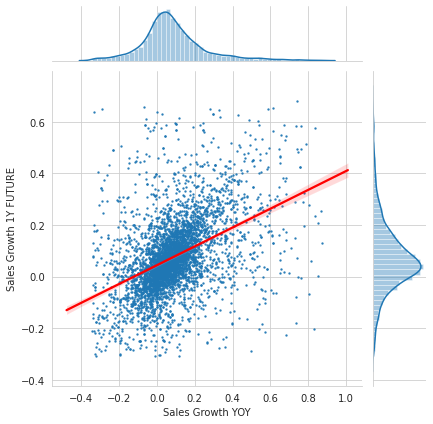

In [22]:
plot_scatter_fit(df=df_signals,
                 x=SALES_GROWTH_YOY,
                 y=SALES_GROWTH_1Y_FUTURE);

Now let us compare the PAST 3-year average Sales Growth to the FUTURE 1-year Sales Growth. The slope of the fitted line is the same as in the plot above which used the YOY Sales Growth as the predictor on the x-axis, but now the fitted line has a much lower $R^2 = 0.07$ because the data-points are more dispersed. This means the PAST 3-year average Sales Growth is a worse predictor than the YOY Sales Growth.

y = 0.37 * x + 0.04 (R^2=0.07, p=0e+00)


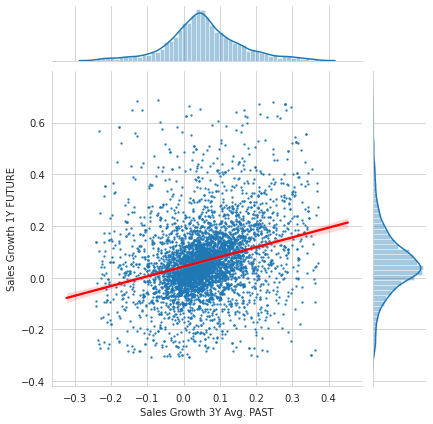

In [23]:
plot_scatter_fit(df=df_signals,
                 x=SALES_GROWTH_3Y_PAST,
                 y=SALES_GROWTH_1Y_FUTURE);

Now consider the YOY Sales Growth versus the FUTURE 3-year average Sales Growth. The scatter-plot does seem to have a trend, but due to the many outliers, the fitted line has a low $R^2 = 0.14$.

y = 0.24 * x + 0.05 (R^2=0.14, p=0e+00)


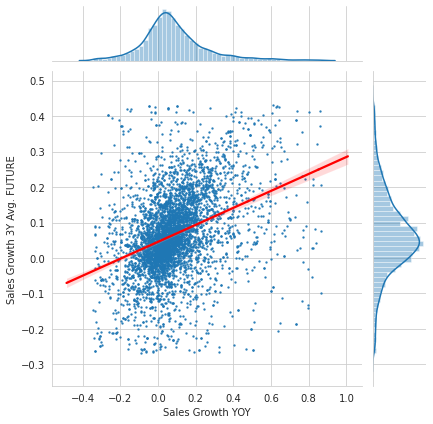

In [24]:
plot_scatter_fit(df=df_signals,
                 x=SALES_GROWTH_YOY,
                 y=SALES_GROWTH_3Y_FUTURE);

Finally we can try the PAST 3-year average Sales Growth versus the FUTURE 3-year average Sales Growth, which has a poor line-fit with $R^2 = 0.07$.

y = 0.29 * x + 0.04 (R^2=0.07, p=3e-170)


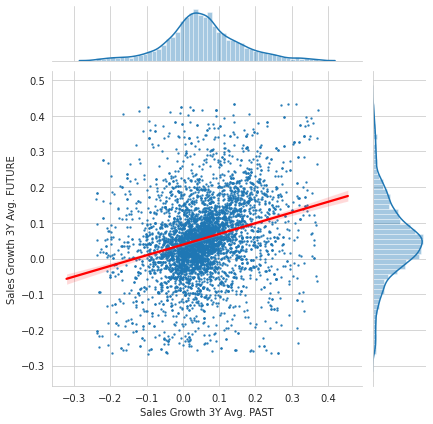

In [25]:
plot_scatter_fit(df=df_signals,
                 x=SALES_GROWTH_3Y_PAST,
                 y=SALES_GROWTH_3Y_FUTURE);

## Assets Growth

Let us now consider the PAST Year-Over-Year (YOY) Assets Growth, which compares the company's quarterly Total Assets to the same quarter in the previous year. This does not predict the FUTURE 1-year Sales Growth very well, as the fitted line only has $R^2 = 0.12$.

y = 0.28 * x + 0.05 (R^2=0.12, p=0e+00)


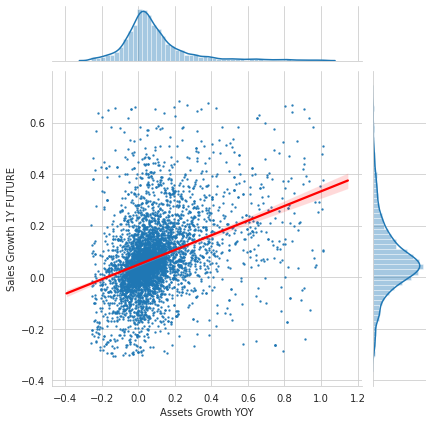

In [26]:
plot_scatter_fit(df=df_signals,
                 x=ASSETS_GROWTH_YOY,
                 y=SALES_GROWTH_1Y_FUTURE);

The YOY Assets Growth has even less predicting power for the FUTURE 3-year average Sales Growth, where the fitted line now only has $R^2 = 0.09$.

y = 0.20 * x + 0.05 (R^2=0.09, p=0e+00)


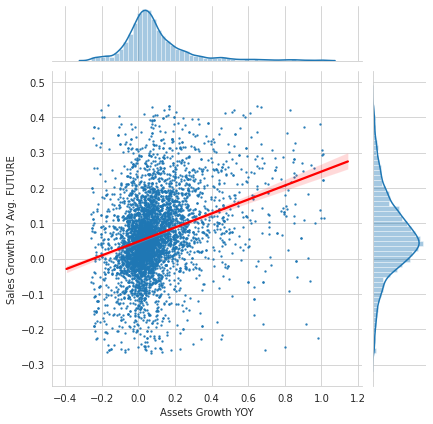

In [27]:
plot_scatter_fit(df=df_signals,
                 x=ASSETS_GROWTH_YOY,
                 y=SALES_GROWTH_3Y_FUTURE);

We can also consider the Quarter-Over-Quarter (QOQ) Assets Growth, but that has even weaker predicting power for the FUTURE 1-year Sales Growth with $R^2 = 0.05$.

y = 0.55 * x + 0.07 (R^2=0.05, p=0e+00)


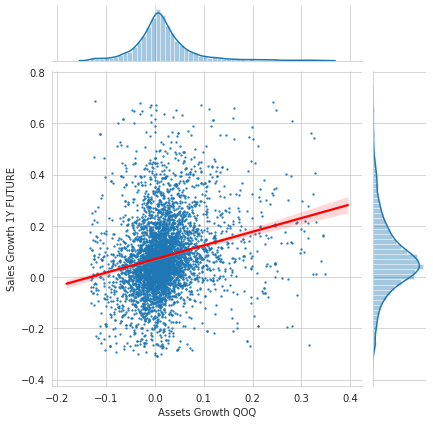

In [28]:
plot_scatter_fit(df=df_signals,
                 x=ASSETS_GROWTH_QOQ,
                 y=SALES_GROWTH_1Y_FUTURE);

## Acquisitions

Now we will consider how Acquisitions and Divestitures may affect the FUTURE Sales Growth. This is when a company buys another company, or it sells a part of its business to someone else. It makes sense if this affects the FUTURE Sales Growth. We will the following ratio between the Net Acquisitions and Total Assets as the predictor signal:

$$
\frac{Net\ Cash\ From\ Acquisitions\ \&\ Divestitures\ TTM}{Total\ Assets\ TTM}
$$

The scatter-plot shows that this ratio has a weak correlation with FUTURE 1-year Sales Growth.

y = 0.45 * x + 0.06 (R^2=0.04, p=1e-119)


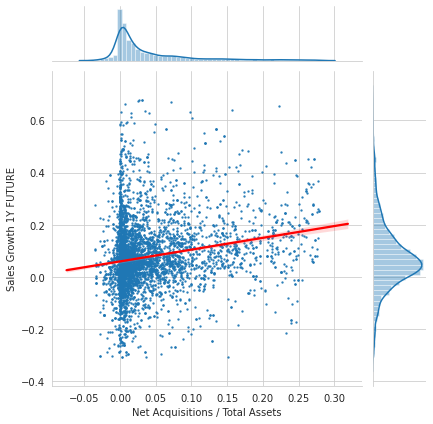

In [29]:
plot_scatter_fit(df=df_signals,
                 x=ACQ_ASSETS_RATIO,
                 y=SALES_GROWTH_1Y_FUTURE);

We can also consider how this Acquisitions/Assets ratio may predict FUTURE 3-year average Sales Growth, which looks very similar:

y = 0.34 * x + 0.05 (R^2=0.04, p=3e-70)


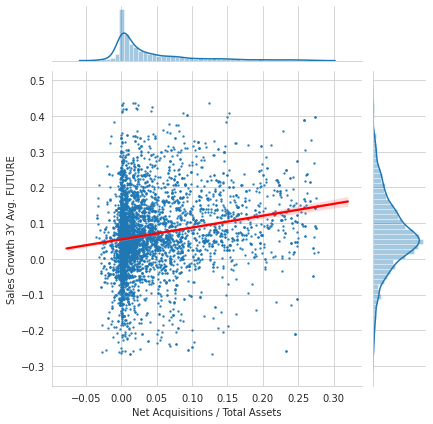

In [30]:
plot_scatter_fit(df=df_signals,
                 x=ACQ_ASSETS_RATIO,
                 y=SALES_GROWTH_3Y_FUTURE);

Let us now try and zoom in on these scatter-plots by only considering the Acquisitions/Assets ratios that are above 0.1, that is, the Net Acquisitions are greater than 10% of the Total Assets. Although this plot has an $R^2$ close to zero because the data-points are so dispersed, the plot shows that higher Acquisitions/Assets ratios usually result in FUTURE 1-year Sales Growth between 0% and 40%, with some outliers.

y = 0.38 * x + 0.07 (R^2=0.02, p=1e-08)


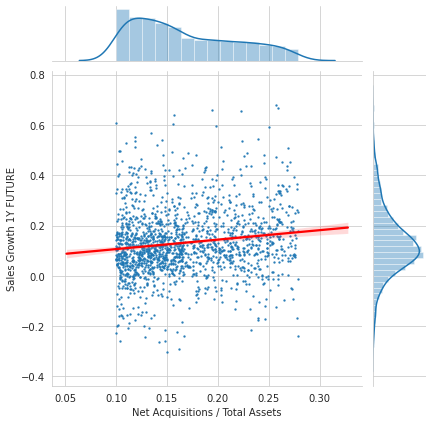

In [31]:
# Select a subsection of the data.
mask = (df_signals[ACQ_ASSETS_RATIO] > 0.1)
df = df_signals.loc[mask]

plot_scatter_fit(df=df,
                 x=ACQ_ASSETS_RATIO,
                 y=SALES_GROWTH_1Y_FUTURE);

We can make the same plot for FUTURE 3-year average Sales Growth, which shows that higher Acquisitions/Assets ratios usually result in 3-year average Sales Growth between zero and 20% (these are annualized growth-rates), again with some outliers:

y = 0.21 * x + 0.07 (R^2=0.01, p=9e-04)


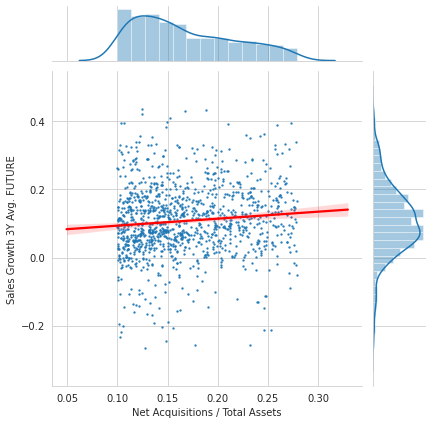

In [32]:
plot_scatter_fit(df=df,
                 x=ACQ_ASSETS_RATIO,
                 y=SALES_GROWTH_3Y_FUTURE);

## Research & Development

Let us now consider a company's investment in Research & Development relative to its Revenue. This might indicate whether or not companies that spend more of their Revenue on R&D also have a greater tendency to grow their future sales. The ratio is simply defined as:

$$
    \frac{Research\ \&\ Development\ TTM}{Revenue\ TTM}
$$

The scatter-plot has a lot of outliers:

y = 0.02 * x + 0.08 (R^2=0.00, p=1e-04)


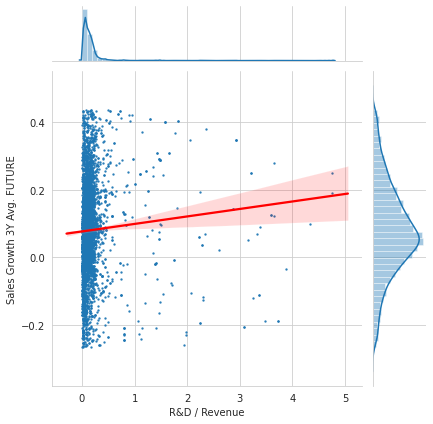

In [33]:
plot_scatter_fit(df=df_signals,
                 x=RD_REVENUE,
                 y=SALES_GROWTH_3Y_FUTURE);

We can remove the outliers for the R&D/Revenue ratio, which indicates that more R&D has a tendency to result in higher FUTURE 3-year average Sales Growth, although with $R^2$ near zero because the data-points are so dispersed.

y = 0.20 * x + 0.06 (R^2=0.02, p=3e-43)


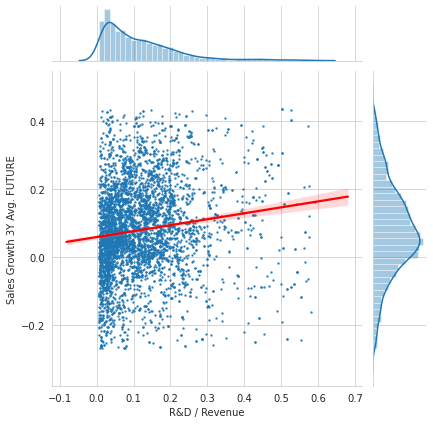

In [34]:
# Remove outliers.
mask = (df_signals[RD_REVENUE] < 0.6)
df = df_signals.loc[mask]

plot_scatter_fit(df=df,
                 x=RD_REVENUE,
                 y=SALES_GROWTH_3Y_FUTURE);

We can also make a scatter-plot where the dots are colored by the size of the company's Revenue, to see if the combination of the R&D / Revenue ratio and the size of the Revenue can help predict the FUTURE 3-year average Sales Growth. But as we can see, there does not appear to be any relation between these.

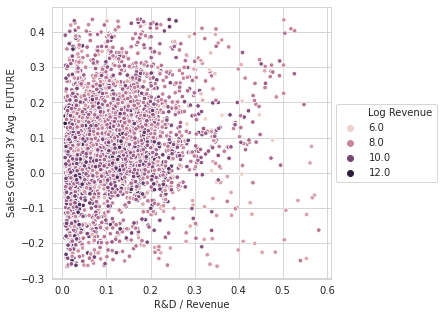

In [35]:
plot_scatter(df=df, hue=LOG_REVENUE,
             x=RD_REVENUE,
             y=SALES_GROWTH_3Y_FUTURE);

## Dividend Payout Ratio

The Dividend Payout Ratio measures how much of the company's earnings are paid out as dividends to shareholders. We might expect that companies that spend less money on dividends, presumably spend more money on growing their business. We will use a slightly different formula for the Payout Ratio than people normally use, as we will use the Free Cash Flow instead of the reported Net Income:

$$
Payout\ Ratio = \frac{Dividends\ Paid\ TTM}{Free\ Cash\ Flow\ TTM} = \frac{Dividends\ Paid\ TTM}{Net\ Cash\ From\ Operations\ TTM - Capital\ Expenditures\ TTM}
$$

The scatter-plot shows a tendency for higher Dividend Payout Ratios to result in lower 1-year Sales Growth, although the $R^2$ is nearly zero because the data-points are so dispersed.

y = -0.06 * x + 0.09 (R^2=0.01, p=6e-112)


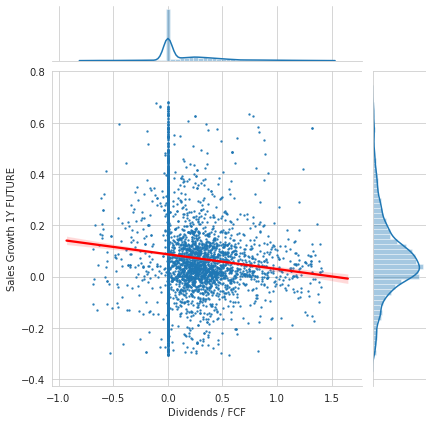

In [36]:
plot_scatter_fit(df=df_signals,
                 x=PAYOUT_RATIO,
                 y=SALES_GROWTH_1Y_FUTURE);

In the scatter-plot above, there are many points where Dividends / FCF = 0 because many companies do not pay any dividends. If we remove those points, then we still get a weak tendency between higher Dividend Payout Ratios and lower Sales Growth, again with $R^2$ near zero.

y = -0.03 * x + 0.07 (R^2=0.01, p=9e-28)


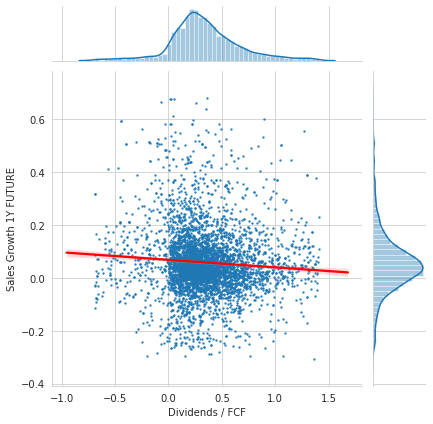

In [37]:
# Remove data-points that are zero.
mask = (df_signals[PAYOUT_RATIO] != 0)
df = df_signals.loc[mask]

# Plot the result.
plot_scatter_fit(df=df,
                 x=PAYOUT_RATIO,
                 y=SALES_GROWTH_1Y_FUTURE);

It would make intuitive sense if the FUTURE Sales Growth would be related to both the Dividend Payout Ratio and the Return On Equity (ROE), because the Payout Ratio indicates how much of the earnings are retained by the company, and the ROE indicates how much the company makes on its retained earnings.

We can make a scatter-plot with the Dividend Payout Ratio on the x-axis, and the FUTURE 1-year Sales Growth on the y-axis as usual, but then we set the hue or color to be the ROE. As we can see from the scatter-plot below, the combination of Payout Ratio and ROE does not seem to improve the prediction of the FUTURE 1-year Sales Growth.

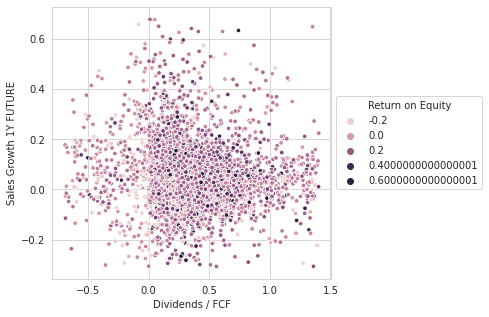

In [38]:
# Limit the ROE values to make it clearer.
df2 = sf.winsorize(df=df, columns=[ROE], clip=True)

plot_scatter(df=df2, hue=ROE,
             x=PAYOUT_RATIO, y=SALES_GROWTH_1Y_FUTURE);

## Payout & Buyback Ratio

In the last few decades, share buybacks have overtaken dividends as the main form of "trying to" return capital to shareholders. I write "trying to" because share buybacks can be extremely destructive to shareholder value if the share-price is too high relative to the "intrinsic value" of the shares. I have made an elaborate theory on that subject [here](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsk2b8Y-MFU6W_rnCgwN51Ef).

Regardless of whether or not the share buybacks will be good for long-term shareholder value, it is still a fact that it lowers the amount of cash that the company could otherwise spend on growing the business. So let us augment the Dividend Payout Ratio with the share buybacks. The new ratio is defined as:

$$
Payout\ Buyback\ Ratio = \frac{Dividend\ Payout\ TTM + Net\ Share\ Buyback\ TTM}{Free\ Cash\ Flow\ TTM}
$$

The scatter-plot looks quite similar to the one above for the Dividend Payout Ratio, once again it has a weak downwards-trend but the $R^2$ is nearly zero because the data-points are so dispersed.

y = -0.02 * x + 0.08 (R^2=0.01, p=1e-63)


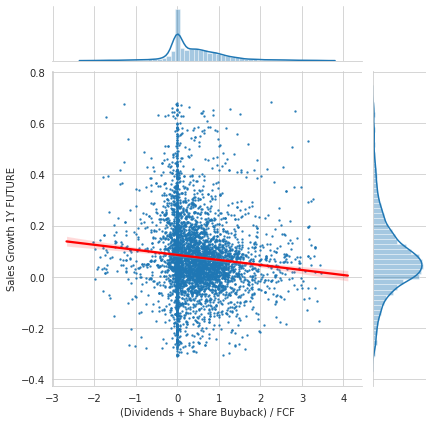

In [39]:
plot_scatter_fit(df=df_signals,
                 x=PAYOUT_BUYBACK_RATIO,
                 y=SALES_GROWTH_1Y_FUTURE);

Because the numerator contains both the Dividend Payout and Net Share Buyback, there are fewer data-points that are exactly zero. Nevertheless, let us try and remove those zero data-points and redo the scatter-plot. This also gives a weak downwards trend with nearly zero $R^2$.

y = -0.02 * x + 0.09 (R^2=0.01, p=8e-81)


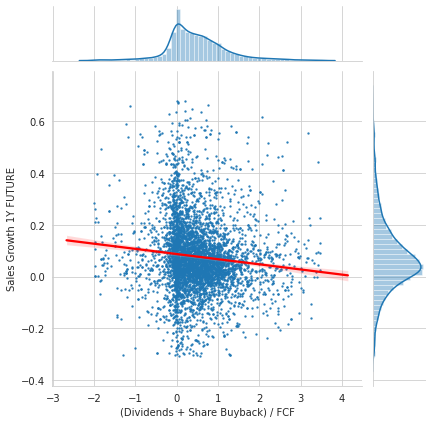

In [40]:
# Remove data-points that are zero.
mask = (df_signals[PAYOUT_BUYBACK_RATIO] != 0)
df = df_signals.loc[mask]

# Plot the result.
plot_scatter_fit(df=df,
                 x=PAYOUT_BUYBACK_RATIO,
                 y=SALES_GROWTH_1Y_FUTURE);

## Capital Expenditures / Depreciation

When a company buys an asset, the cash is paid immediately but its cost is subtracted from the operating income over a number of years, which is called Depreciation. A similar concept for intangible assets is known as Amortization. The SimFin database combines these two items into "Depreciation & Amortization" in the Cash-Flow Statement. It is important to understand that these are accounting-numbers and **not** cash-numbers.

The cash used to buy new assets is called Capital Expenditures (CapEx). The SimFin database lists this item as "Change in Fixed Assets & Intangibles" in the Cash-Flow Statement.

If the company has accurately estimated the Depreciation and Amortization costs, then a difference between those and the CapEx could theoretically be used to estimate whether the company is growing or shrinking its operating capabilities. For example, if the company is improving or expanding its factories more than regular maintenance, then that might indicate growth in future sales, and conversely, if the company is neglecting to maintain its factories, then that might indicate a decline in future sales.

Let us test this notion by considering the ratio between the CapEx and Depreciation & Amortization, defined as:

$$
    \frac{CapEx}{Depreciation\ \&\ Amortization} =
    \frac{Change\ in\ Fixed\ Assets\ \&\ Intangibles}{Depreciation\ \&\ Amortization}
$$

The scatter-plot below shows that there is a weak tendency for the FUTURE 1-year Sales Growth to increase as CapEx becomes larger than the Depreciation & Amortization. But the $R^2$ is nearly zero because the data-points are so dispersed.

y = 0.01 * x + 0.06 (R^2=0.00, p=3e-32)


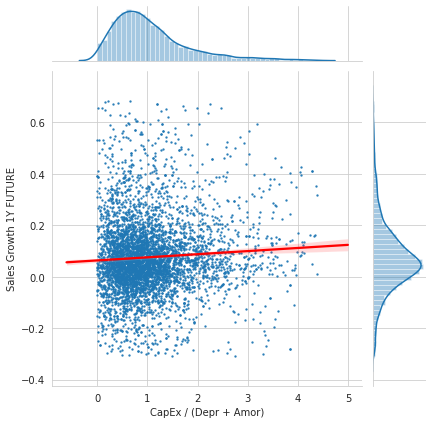

In [41]:
plot_scatter_fit(df=df_signals,
                 x=CAPEX_DEPR_RATIO,
                 y=SALES_GROWTH_1Y_FUTURE);

We can also try and make a scatter-plot for the FUTURE 3-year average Sales Growth. This shows practically no predictive power of the CapEx / Depreciation ratio.

y = 0.01 * x + 0.06 (R^2=0.00, p=2e-10)


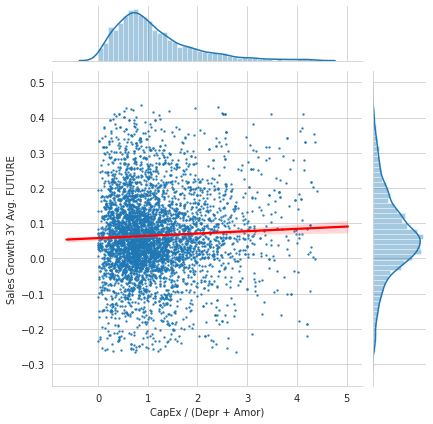

In [42]:
plot_scatter_fit(df=df_signals,
                 x=CAPEX_DEPR_RATIO,
                 y=SALES_GROWTH_3Y_FUTURE);

We can also try and consider whether the 1-year change in the CapEx / Depreciation ratio has any predictive power for the FUTURE 1-year Sales Growth. The scatter-plot and fitted line shows that there is practically no relation.

y = 0.00 * x + 0.07 (R^2=0.00, p=4e-02)


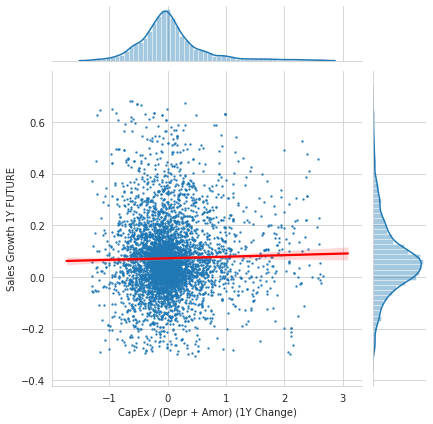

In [43]:
# Name of the data-column.
CAPEX_DEPR_RATIO_CHG = rename_chg(CAPEX_DEPR_RATIO)

plot_scatter_fit(df=df_signals,
                 x=CAPEX_DEPR_RATIO_CHG,
                 y=SALES_GROWTH_1Y_FUTURE);

## Revenue Size

There is a common belief that small-cap and mid-cap stocks tend to outperform large-cap stocks in the long run, because the smaller companies have higher sales-growth.

We can also test this notion by making a scatter-plot with the TTM Revenue on the x-axis and the FUTURE 1-year Sales Growth on the y-axis. We will actually use the Log10 of the Revenue, which basically counts the "number of zeros" in the Revenue, which makes the Revenue numbers on the x-axis more evenly spread out.

The scatter-plot shows that there is a weak tendency for companies with lower Revenue to have higher Sales Growth, but the data-points are so dispersed that the $R^2$ is nearly zero.

y = -0.02 * x + 0.24 (R^2=0.01, p=3e-100)


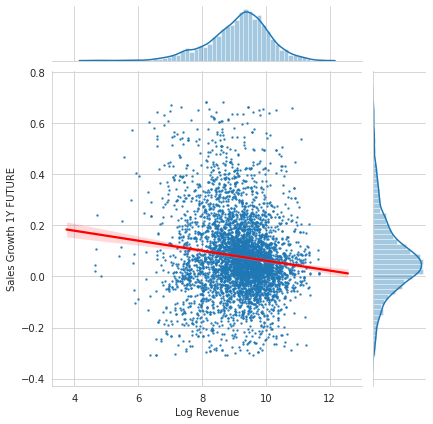

In [44]:
plot_scatter_fit(df=df_signals,
                 x=LOG_REVENUE,
                 y=SALES_GROWTH_1Y_FUTURE);

We can also make the scatter-plot for the FUTURE 3-year average Sales Growth, which looks very similar and only has a marginally better $R^2$ that is still close to zero.

y = -0.02 * x + 0.23 (R^2=0.02, p=3e-108)


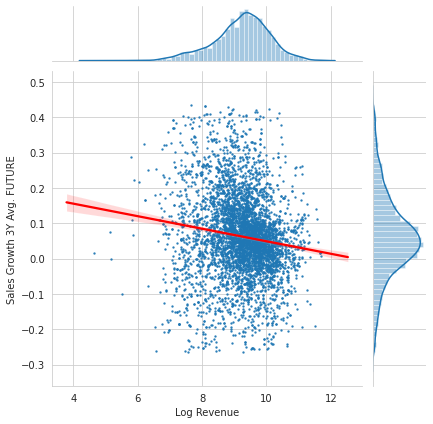

In [45]:
plot_scatter_fit(df=df_signals,
                 x=LOG_REVENUE,
                 y=SALES_GROWTH_3Y_FUTURE);

## Inventory Turnover

Inventory Turnover is defined as the yearly Revenue divided by the Inventory, so it measures how many times per year the inventory is "turned over" by selling it to customers. Changes in a company's Inventory Turnover may indicate changes in demand for the company's products, which might predict future growth or decline in its sales.

We can test this notion by considering the change in the Inventory Turnover from the previous year, and see if that has any relation to the FUTURE 1-year Sales Growth. The following scatter-plot shows a weak tendency for this and the $R^2$ is zero.

y = -0.04 * x + 0.06 (R^2=0.00, p=1e-13)


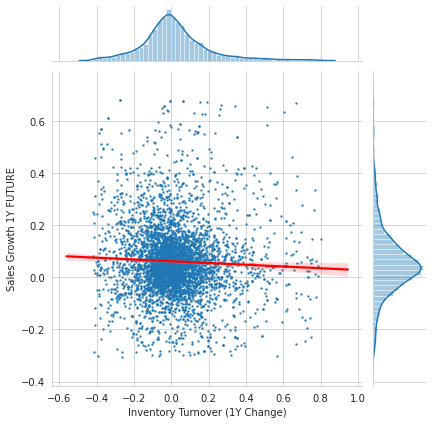

In [46]:
# Name of the data-column.
INVENTORY_TURNOVER_CHG = rename_chg(INVENTORY_TURNOVER)

plot_scatter_fit(df=df_signals,
                 x=INVENTORY_TURNOVER_CHG,
                 y=SALES_GROWTH_1Y_FUTURE);

## Gross Profit Margin

Companies with higher Gross Profit Margins often have some unique product or service. Let us test if this also means they have higher Sales Growth.

The following scatter-plot shows a weak tendency for companies with higher Gross Profit Margin to also have higher Sales Growth, but the data-points are so dispersed that the $R^2$ is nearly zero.

y = 0.10 * x + 0.03 (R^2=0.02, p=9e-157)


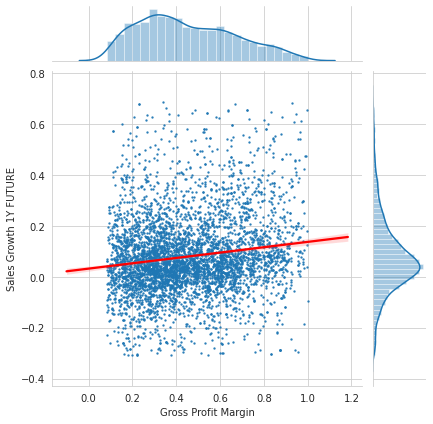

In [47]:
# Remove outliers in the data.
mask = (df_signals[GROSS_PROFIT_MARGIN] < 1.0)
df = df_signals.loc[mask]

plot_scatter_fit(df=df,
                 x=GROSS_PROFIT_MARGIN,
                 y=SALES_GROWTH_1Y_FUTURE);

If we use the FUTURE 3-year average Sales Growth, then the scatter-plot looks almost the same:

y = 0.08 * x + 0.03 (R^2=0.02, p=8e-125)


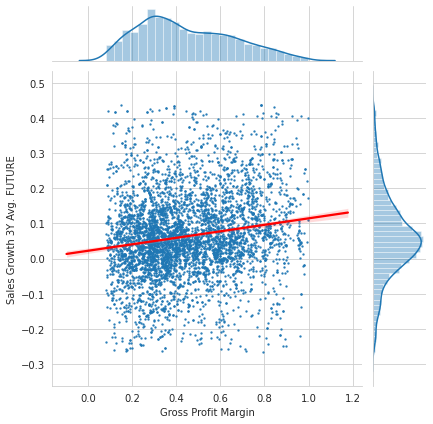

In [48]:
plot_scatter_fit(df=df,
                 x=GROSS_PROFIT_MARGIN,
                 y=SALES_GROWTH_3Y_FUTURE);

We might imagine that a significant change in Gross Profit Margin would reflect a change in demand for the company's product or services, which in turn might lead to changes in the company's future sales. We can test that notion with the following scatter-plot, which shows that there is no such relation.

y = 0.05 * x + 0.07 (R^2=0.00, p=1e-05)


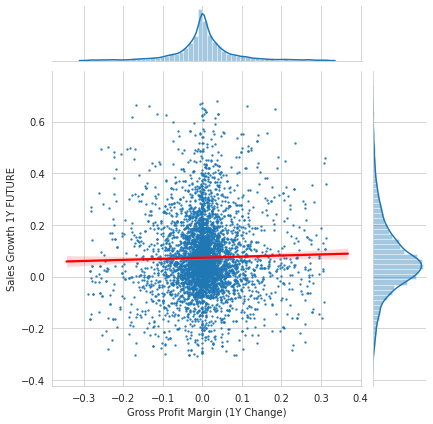

In [49]:
# Name of the column.
GROSS_PROFIT_MARGIN_CHG = rename_chg(GROSS_PROFIT_MARGIN)

plot_scatter_fit(df=df_signals,
                 x=GROSS_PROFIT_MARGIN_CHG,
                 y=SALES_GROWTH_1Y_FUTURE);

## Interest Coverage

A company's Interest Coverage measures how many times it can pay the interest on its debt from its Operating Income. Companies with low Interest Coverage risk bankruptcy in case of a period with poor business.

We might imagine that a company's Interest Coverage is related to its capabilities for growing future Sales. We can test this notion in the following scatter-plot, which shows that there is generally no relation between Interest Coverage and FUTURE 1-year Sales Growth.

y = 0.00 * x + 0.07 (R^2=0.00, p=4e-02)


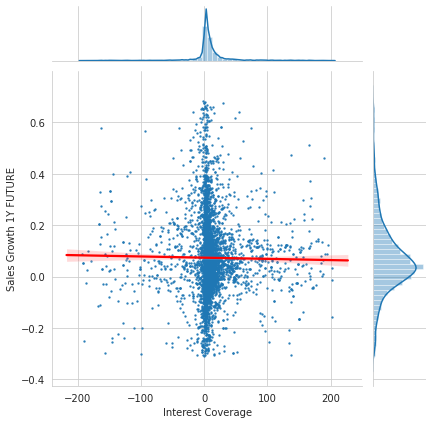

In [50]:
plot_scatter_fit(df=df_signals,
                 x=INTEREST_COVERAGE,
                 y=SALES_GROWTH_1Y_FUTURE);

We can also test if a change in the Interest Coverage can predict the FUTURE 1-year Sales Growth, but once again, the scatter-plot below shows that there is no such relation.

y = -0.00 * x + 0.07 (R^2=0.00, p=1e-04)


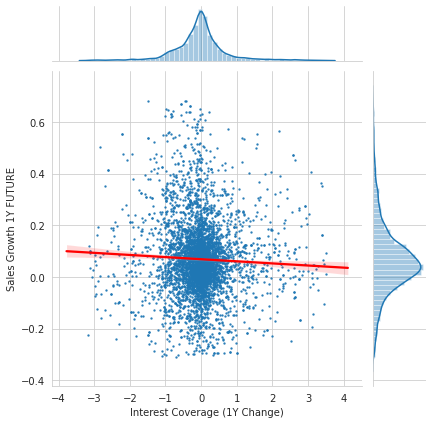

In [51]:
# Name of the data-column.
INTEREST_COVERAGE_CHG = rename_chg(INTEREST_COVERAGE)

plot_scatter_fit(df=df_signals,
                 x=INTEREST_COVERAGE_CHG,
                 y=SALES_GROWTH_1Y_FUTURE);

## Conclusion

Forecasting the Sales Growth is an essential component of long-term stock forecasting. This was a basic statistical study of which signals could be used to predict the FUTURE 1-year and 3-year average Sales Growth.

In summary, the signals we tested here, were all very weak predictors for the FUTURE 1-year and 3-year average Sales Growth. Perhaps they could be useful if multiple signals are combined, or when making a diversified portfolio of many stocks.

These are the results:

- The strongest predictor for the FUTURE 1-year Sales Growth was the PAST Year-Over-Year (YOY) Sales Growth, which compares the quarterly sales to the same quarter in the previous year. The data-points were very dispersed so the line-fitting only had $R^2 = 0.2$. When using the YOY Sales Growth to predict the FUTURE 3-year average Sales Growth the line-fitting was even worse with only $R^2 = 0.14$.

- The YOY Assets Growth predicted the FUTURE 1-year Sales Growth with $R^2 = 0.12$, and it predicted the FUTURE 3-year average Sales Growth with $R^2 = 0.09$.

- Larger Net Acquisitions & Divestitures relative to the Total Assets had a positive correlation with FUTURE 1-year and 3-year average Sales Growth, although the data-points were so dispersed that the $R^2$ was nearly zero.

- Companies whose Net Acquisitions were greater than 10% of the Total Assets mostly had positive Sales Growth between 0-20% per year on average for the following 3 years, with a few outliers beyond this range.

- Larger Research & Development relative to the Revenue had a positive correlation with FUTURE 3-year average Sales Growth, but the data-points were so dispersed that the $R^2$ was nearly zero.

- Larger Dividend Payouts and Share Buybacks relative to the Free Cash Flow had a negative correlation with the FUTURE 1-year Sales Growth, but the data-points were so dispersed that the $R^2$ was nearly zero.

- Larger Capital Expenditures (CapEx) relative to the Depreciation & Amortization had a positive correlation with the FUTURE 1-year Sales Growth, but the data-points were so dispersed that the $R^2$ was zero.

- Larger Revenue for a company had a negative correlation with FUTURE 1-year Sales Growth, but the data-points were so dispersed that the $R^2$ was zero.

- Changes in Inventory Turnover compared to the previous year had a negative correlation with the FUTURE 1-year Sales Growth, but the data-points were so dispersed that the $R^2$ was zero.

- Larger Gross Profit Margins had a positive correlation with FUTURE 1-year Sales Growth, but the data-points were so dispersed that the $R^2$ was nearly zero.

- Interest Coverage had no correlation with FUTURE 1-year Sales Growth.

Also note that we used data for a fairly short period of time, which ended in April 2020 and only went back about 6 years on average for the individual stocks, with the max period being 11 years for one stock. Ideally this kind of study would be done with 20-30 years of data, in which case we might be able to find stronger predictors for Sales Growth over 5-10 year periods.

## License (MIT)

Copyright (c) 2020 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.